## ひらがな手書きの文字認識

### データのダウンロード（NDL LABからひらがなのデータ）
#### XXXXXはNotebookID

In [3]:
cd /mnt/notebooks/XXXXX/Platform_handson/hiragana_classify

/mnt/notebooks/1728382888794/Platform_handson/hiragana_classify


In [4]:
# home配下にdataを配置する
!wget http://lab.ndl.go.jp/dataset/hiragana73.zip -P /home/data

--2019-04-04 09:17:44--  http://lab.ndl.go.jp/dataset/hiragana73.zip
Resolving lab.ndl.go.jp (lab.ndl.go.jp)... 202.32.173.150
Connecting to lab.ndl.go.jp (lab.ndl.go.jp)|202.32.173.150|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://lab.ndl.go.jp/dataset/hiragana73.zip [following]
--2019-04-04 09:17:44--  https://lab.ndl.go.jp/dataset/hiragana73.zip
Connecting to lab.ndl.go.jp (lab.ndl.go.jp)|202.32.173.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233312433 (223M) [application/zip]
Saving to: ‘/home/data/hiragana73.zip’

hiragana73.zip      100%[===================>] 222.50M  17.6MB/s    in 19s     

2019-04-04 09:18:03 (11.5 MB/s) - ‘/home/data/hiragana73.zip’ saved [233312433/233312433]



In [5]:
!unzip /home/data/hiragana73.zip -d /home/data/ > /dev/null

In [6]:
# フォルダのリネーム（命名がユニコードになっているので、indexに変換する）
!sh ./tool/rename.sh

In [7]:
ls -al /home/data/hiragana73

total 4676
drwxr-xr-x 75 root root  4096 Apr  4 09:18 ./
drwxr-xr-x  3 root root    46 Apr  4 09:18 ../
drwxr-xr-x  2 root root 45056 Sep  8  2016 0/
drwxr-xr-x  2 root root 45056 Sep  8  2016 1/
drwxr-xr-x  2 root root 40960 Sep  8  2016 10/
drwxr-xr-x  2 root root 45056 Sep  8  2016 11/
drwxr-xr-x  2 root root 40960 Sep  8  2016 12/
drwxr-xr-x  2 root root 45056 Sep  8  2016 13/
drwxr-xr-x  2 root root 40960 Sep  8  2016 14/
drwxr-xr-x  2 root root 49152 Sep  8  2016 15/
drwxr-xr-x  2 root root 40960 Sep  8  2016 16/
drwxr-xr-x  2 root root 49152 Sep  8  2016 17/
drwxr-xr-x  2 root root 40960 Sep  8  2016 18/
drwxr-xr-x  2 root root 49152 Sep  8  2016 19/
drwxr-xr-x  2 root root 45056 Sep  8  2016 2/
drwxr-xr-x  2 root root 40960 Sep  8  2016 20/
drwxr-xr-x  2 root root 45056 Sep  8  2016 21/
drwxr-xr-x  2 root root 45056 Sep  8  2016 22/
drwxr-xr-x  2 root root 49152 Sep  8  2016 23/
drwxr-xr-x  2 root root 40960 Sep  8  2016 24/
drwxr-xr-x  2 root root 49152 Sep  8  2016 25/
drwxr-

In [8]:
# フォルダの一覧を取得する(hiragana73配下)
import os
path = "/home/data/hiragana73/"
folder = os.listdir(path)

### 前処理

In [9]:
import glob
from PIL import Image
import numpy as np
import random
image_size = 48
 
X_train = []
Y_train = []
X_test = []
Y_test = []
for index, name in enumerate(folder):
  
    #フォルダの一覧をリストとして取得する
    dir = path + name
    files = glob.glob(dir + "/*.png")
    random.shuffle(files)
    
    # 学習とテストで 8:2 のデータ割合に分ける
    split_num = len(files)*0.8
    num = 0
    for i, file in enumerate(files):
      image = Image.open(file)
      image = image.convert("RGB")
      #image = image.convert('L')
      image = image.resize((image_size, image_size))
      data = np.asarray(image)
      if split_num > num:
        X_train.append(data)
        Y_train.append(name)
      else:
        X_test.append(data)
        Y_test.append(name)
      num += 1
 
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [10]:
# ラベルと対象データを確認
Y_test[1]

'41'

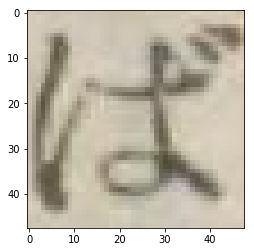

In [12]:
import matplotlib.pyplot as plt
im_list = np.asarray(X_train[1])
plt.imshow(im_list)
plt.show()

In [13]:
# trainとtestがデータが分割されていることを確認する
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))

64027
64027
15973
15973


In [14]:
# 0-255の整数値を0〜1の小数に変換する(正規化)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [15]:
# one-hot vector形式に変換する
from keras.utils import np_utils
Y_train = np_utils.to_categorical(Y_train, 73)
Y_test = np_utils.to_categorical(Y_test, 73)

Using TensorFlow backend.


In [16]:
# モデルの定義（別資料にて説明）
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(73, activation='softmax'))


In [17]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [18]:
history = model.fit(X_train, Y_train,
                    batch_size=128,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, Y_test))

Train on 64027 samples, validate on 15973 samples
Epoch 1/20
64027/64027 [==============================] - 121s 2ms/step - loss: 4.1930 - acc: 0.0322 - val_loss: 3.7276 - val_acc: 0.1939
Epoch 2/20
64027/64027 [==============================] - 16s 244us/step - loss: 2.3853 - acc: 0.3795 - val_loss: 0.8598 - val_acc: 0.8327
Epoch 3/20
64027/64027 [==============================] - 16s 248us/step - loss: 0.9373 - acc: 0.7392 - val_loss: 0.3702 - val_acc: 0.9158
Epoch 4/20
64027/64027 [==============================] - 16s 248us/step - loss: 0.5400 - acc: 0.8489 - val_loss: 0.2436 - val_acc: 0.9376
Epoch 5/20
64027/64027 [==============================] - 16s 244us/step - loss: 0.3719 - acc: 0.8955 - val_loss: 0.1733 - val_acc: 0.9554
Epoch 6/20
64027/64027 [==============================] - 16s 245us/step - loss: 0.2860 - acc: 0.9210 - val_loss: 0.1325 - val_acc: 0.9634
Epoch 7/20
64027/64027 [==============================] - 16s 245us/step - loss: 0.2355 - acc: 0.9337 - val_loss: 0.1

In [19]:
predict = model.predict(X_test)

In [20]:
len(predict)

15973

In [21]:
# ラベルの設定
label = ["あ","い","う","え","お","か","が","き","ぎ","く","ぐ","け","げ","こ","ご","さ","ざ","し","じ","す","ず","せ","ぜ","そ","ぞ","た","だ","ち","ぢ","つ","づ","て","で","と","ど","な","に","ぬ","ね","の","は","ば","ぱ","ひ","び","ぴ","ふ","ぶ","ぷ","へ","べ","ぺ","ほ","ぼ","ぽ","ま","み","む","め","も","や","ゆ","よ","ら","り","る","れ","ろ","わ","ゐ","ゑ","を","ん"]

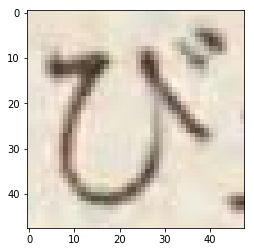

In [22]:
import matplotlib.pyplot as plt
ind = 500
im_list = np.asarray(X_test[ind])
plt.imshow(im_list)
plt.show()

In [23]:
label[predict[ind].tolist().index(max(predict[ind]))]

'び'

In [24]:
#モデルの保存
model.save('./model/hiragana_model.h5', include_optimizer=False)

In [25]:
from keras.models import load_model
import numpy as np
from keras.preprocessing.image import img_to_array, load_img

jpg_name = ''

model=load_model('./model/hiragana_model.h5')

img_path = ('./sample/test2.png')
img = img_to_array(load_img(img_path, target_size=(48,48)))
img_nad = img_to_array(img)/255
img_nad = img_nad[None, ...]

label=["あ","い","う","え","お","か","が","き","ぎ","く","ぐ","け","げ","こ","ご","さ","ざ","し","じ","す","ず","せ","ぜ","そ","ぞ","た","だ","ち","ぢ","つ","づ","て","で","と","ど","な","に","ぬ","ね","の","は","ば","ぱ","ひ","び","ぴ","ふ","ぶ","ぷ","へ","べ","ぺ","ほ","ぼ","ぽ","ま","み","む","め","も","や","ゆ","よ","ら","り","る","れ","ろ","わ","ゐ","ゑ","を","ん"]
pred = model.predict(img_nad, batch_size=1, verbose=0)
score = np.max(pred)
pred_label = label[np.argmax(pred[0])]
print('name:',pred_label)
print('score:',score)

name: う
score: 0.9998498


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [26]:
# HTTPサーバに組みこむ際のサンプルコード
from keras.models import load_model
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input

model=load_model('./model/hiragana_model.h5')

def process_image(img):
    img = Image.fromarray(img)
    img = img.resize((48, 48)).convert('RGB')
    
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x, mode='tf')

    label=["あ","い","う","え","お","か","が","き","ぎ","く","ぐ","け","げ","こ","ご","さ","ざ","し","じ","す","ず","せ","ぜ","そ","ぞ","た","だ","ち","ぢ","つ","づ","て","で","と","ど","な","に","ぬ","ね","の","は","ば","ぱ","ひ","び","ぴ","ふ","ぶ","ぷ","へ","べ","ぺ","ほ","ぼ","ぽ","ま","み","む","め","も","や","ゆ","よ","ら","り","る","れ","ろ","わ","ゐ","ゑ","を","ん"]
    pred = model.predict(x,verbose=0)[0]
    print(pred)
    result_with_labels = [{"label": label[i], "probability": float(score)} for i, score in enumerate(pred)]
    result = {"result":sorted(result_with_labels, key=lambda x: x['probability'], reverse=True)[:5]}

    return result

def handler(iter, context):
    for img in iter:
        yield process_image(img)

In [27]:
#img = Image.open('./test.png')
img = Image.open('./sample/test4.png')
img = np.asarray(img)
process_image(img)

[6.20201754e-05 5.02813391e-09 1.18559008e-04 8.97220671e-01
 1.51385699e-04 7.61348645e-07 3.74160720e-08 2.56456260e-04
 2.33176706e-06 5.84581940e-05 3.82938225e-07 7.17572391e-07
 7.29527938e-10 3.47946276e-04 3.60619597e-05 2.03347387e-04
 5.12403767e-06 4.37260787e-05 4.72494821e-06 1.95332213e-05
 1.15148600e-06 1.26924419e-06 1.30958044e-08 5.63114736e-05
 5.40751955e-07 1.47408559e-06 7.98503752e-09 1.72974724e-05
 2.65006383e-06 8.74790931e-06 1.10876336e-07 1.09738081e-04
 2.17875140e-07 4.55188449e-04 5.15484726e-06 9.50847971e-06
 6.94839673e-06 7.15286706e-06 3.47722525e-05 6.64103436e-06
 3.96921860e-05 1.13478700e-06 1.72629040e-08 1.25830375e-05
 2.33132340e-07 2.46808241e-10 1.76291373e-02 1.10531761e-03
 2.87285438e-05 2.89879040e-07 7.28863233e-06 1.31330887e-06
 2.27091106e-04 1.04905121e-04 5.68578707e-06 3.56018543e-02
 4.04401044e-06 1.58800094e-06 4.66340481e-07 1.84228306e-03
 1.38665177e-06 3.50757631e-07 4.32687020e-03 7.88935053e-04
 3.32585910e-06 3.565941

{'result': [{'label': 'え', 'probability': 0.8972206711769104},
  {'label': 'る', 'probability': 0.035659413784742355},
  {'label': 'ま', 'probability': 0.03560185432434082},
  {'label': 'ふ', 'probability': 0.017629137262701988},
  {'label': 'よ', 'probability': 0.004326870199292898}]}

In [64]:
!apt-get update
!apt-get install zip

Get:1 http://security.ubuntu.com/ubuntu xenial-security InRelease [109 kB]
Get:2 http://archive.ubuntu.com/ubuntu xenial InRelease [247 kB]               
Get:3 http://security.ubuntu.com/ubuntu xenial-security/universe Sources [128 kB]
Get:4 http://archive.ubuntu.com/ubuntu xenial-updates InRelease [109 kB]       
Get:5 http://security.ubuntu.com/ubuntu xenial-security/main amd64 Packages [814 kB]
Get:6 http://archive.ubuntu.com/ubuntu xenial-backports InRelease [107 kB]     
Get:7 http://archive.ubuntu.com/ubuntu xenial/universe Sources [9802 kB]       
Get:8 http://security.ubuntu.com/ubuntu xenial-security/restricted amd64 Packages [12.7 kB]
Get:9 http://security.ubuntu.com/ubuntu xenial-security/universe amd64 Packages [550 kB]
Get:10 http://security.ubuntu.com/ubuntu xenial-security/multiverse amd64 Packages [6117 B]
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu xenial InRelease [18.0 kB]
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu xenial/main amd64 Packages [32

この後、modelフォルダに存在するh5ファイルとmain.pyを圧縮し
ABEJA Platform上にアップロードすることで、HTTPサーバとして活用可能

## Imagegeneratorを使う場合(参考程度に記載)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(rescale=1./255,
    #shear_range=0.1,
    #zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set test split

In [0]:
dir = 'hiragana73'
train_generator = datagen.flow_from_directory(
        dir,     # directory
        target_size=(48, 48),     # input shape (resized to 150x150)
        batch_size=20,
        class_mode='categorical')    # categorical labels

In [0]:
test_generator = datagen.flow_from_directory(
    dir, # same directory as training data
    target_size=(48, 48),
    batch_size=20,
    class_mode='categorical',
    subset='validation') # set as validation data

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(73, activation='softmax'))

from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=354,
      epochs=20,
      validation_data=test_generator,
      validation_steps=56)

In [0]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

test_loss, test_acc = model.evaluate_generator(test_generator, steps=54)
print('test loss:', test_loss)
print('test acc:', test_acc)